In [1]:
import oyster as oy

# Obtaining Pearls of Wisdom from Oyster
## A Walkthrough of Graphical Causal Inference with the Oyster Toolkit

## Table of Contents
- [Introduction](#intro)
- [Preliminaries](#prelim)
    - [Study question 1.4.1](#sq141)
    - [Study question 1.5.1](#sq151)
        - [Causal diagrams as a useful, high-level abstraction for even nonlinear models](#abstraction)
- [Graphical Models and Their Applications](#graphsAndApps)
    - [Study question 2.3.1](#sq231)
        - [D-Separation](#d_sep_graph)
    - [Study question 2.4.1](#sq241)
        - [Implied Independencies as Testable Implications](#impliedIndependencies)
        - [Minimal Separating Sets to Maximize Sample Size](#minsets)
        - [Markov Blankets as Optimal Predictors](#mb)
        - [Causal Diagram Analysis for Variable Selection](#variableSelection)
    - [Study question 2.5.1](#sq251)
        - [Equivalence Classes & CPDAGs for Causal Search and Alternative Hypotheses](#cpdag)
- **[The Effects of Interventions](#interventions)**
    - [Study question 3.3.1](#sq331)
    - [Study question 3.3.2 (Lord's Paradox)](#sq332)
        - [Graphs as a tool for Causal Argumentation](#arg)
    - [Study Question 3.3.3](#sq333)
    - [Study question 3.5.1](#sq351)
        - [Determining Causal Effects Specific to a Subpopulation](#specificEffects)
    - [Controlled Direct Effects](#cde) (Under Contstruction) 
    - Side Doors: Instrumental Variables and General Identifiability
        - [General Identifiability](#id) (Under Construction) 
        - [Instrumental Variables](#givs) (Under Construction)
- [Counterfactuals](#counterfactuals) (Under Construction)

# Introduction <a id="intro"></a>
Learn Oyster in this walkthrough of selected examples from Judea Pearl's *Causal Inference in Statistics: A Primer*.  Credit to Johannes Textor, Andrew Forney, and Judea Pearl for [their approach](http://dagitty.net/primer/) to teaching the R package Daggity.  This walkthrough focuses on study questions that are graphical in nature, so it skips several of the more analytic questions from the primer and Textor's walkthrough, while adding a couple questions beyond what Textor covers.  Along the way I try to convey some of what I learned from the Primer in my own words, focusing in particular on the application of causal inference to analysis and decisionmaking.  These are usually keyed with ***bold italics*** and are linked at the third indent level in the table of contents.

### Study Question 1.4.1 <a id="sq141"></a>
#### Consider the graph shown in Figure 1.8...

In Oyster, causal diagrams (Pearl often calls them simply "Graphs" or "Directed Acyclic Graphs (DAGs)"; so will we) are instances of the `CausalDiagram` class. The easiest way to initialize a `CausalDiagram` is by providing a list of two-tuples corresponding to the edges in the graph.  Order is important, as the edges are directed from the first node in the tuple to the second.

In [2]:
fig1_8 = oy.CausalDiagram(([('X', 'W'), ('X', 'Y'), 
                            ('W', 'Y'), ('W', 'Z'), 
                            ('Y', 'T'), ('Y', 'Z'), 
                            ('Z', 'T')]))

CausalDiagram subclasses the DiGraph class in the excellent [NetworkX](https://networkx.github.io) package, so many methods and attributes from `networkx.DiGraph` are available in `oyster.CausalDiagram`. In fact, Oyster relies on NetworkX for most of its backend, so many thanks to the NetworkX team.

In [3]:
fig1_8.nodes # the set of nodes in fig1_8

NodeView(('X', 'W', 'Y', 'Z', 'T'))

Use Oyster's `draw` function to draw graphs.  You can specify a dictionary of absolute positions to for where to draw the graph's nodes using the `pos` keyword argument.

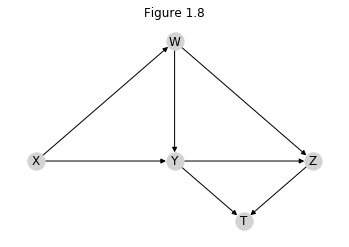

In [4]:
oy.draw(fig1_8, 
        pos={'X': (0,0), 'W': (1,1), 'Y': (1,0), 'Z': (2,0), 'T':(1.5, -.5)},
        title='Figure 1.8')

Oyster provides many pre-specified example graphs in the `oyster.example` module.  Many graphs from figures in the Primer are available as `oy.ex.primer['fig<Chapter#>_<Fig#>']`.  

If done this way, `oy.draw` will automatically resolve positions for these graphs as drawn in the book.

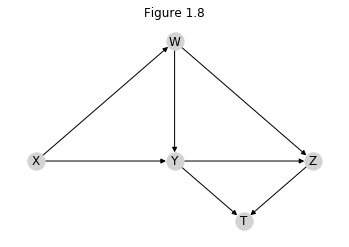

In [5]:
fig1_8_another_way = oy.ex.primer['fig1_8']
oy.draw(fig1_8_another_way, title='Figure 1.8')

Oyster provides several utility functions for examining ancestral elements of a graph:

#### a) Name all of the parents of Z

In [6]:
oy.Pa(fig1_8, 'Z')

{'W', 'Y'}

#### b) Name all of the ancestors of Z

In [7]:
oy.An(fig1_8, 'Z')

{'W', 'X', 'Y'}

*There is some disagreement in the literature about whether the set of a node's ancestors includes the node itself.  Oyster does not include it, the R package Daggity does.

#### c) Name all of the children of W

In [8]:
oy.Ch(fig1_8, 'W')

{'Y', 'Z'}

#### d) Name all of the descendants of W

In [9]:
oy.De(fig1_8, 'W')

{'T', 'Y', 'Z'}

*There is some disagreement in the literature about whether to include the node itself in its set of descendants.  Oyster does not, the R package Daggity does.

#### e) Draw all (simple) paths between X and T

In Pearl's causal lexicon, a simple path is any adjacent set of edges between two nodes.

Oyster's `paths` function returns the paths between two nodes in a graph as a collection of subgraphs, each representing a path.  The `print_path` function prints these linear subgraphs as text.

In [10]:
for path in oy.paths(fig1_8, 'X', 'T'): 
    oy.print_path(path, start='X') 

X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> W -> Z -> T
X -> W -> Z <- Y -> T
X -> Y -> T
X -> Y <- W -> Z -> T
X -> Y -> Z -> T


Or simply use the `print_paths` function:

In [11]:
oy.print_paths(fig1_8, 'X', 'T')

X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> W -> Z -> T
X -> W -> Z <- Y -> T
X -> Y -> T
X -> Y <- W -> Z -> T
X -> Y -> Z -> T


#### f) Draw all directed paths between X and T

Set keyword argument `directed=True` to show only paths that take direction into account.

In [12]:
oy.print_paths(fig1_8, 'X', 'T', directed=True)

X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> W -> Z -> T
X -> Y -> T
X -> Y -> Z -> T


### Study Question 1.5.1 <a id="sq151"></a>
Suppose we have the following structural causal model (SCM).  Assume all exogenous variables $U_{i}$ are independent and that the expected value of each is 0.

\begin{equation*}
V = \{X, Y, Z\}, \hspace{20pt}
U = \{U_X, U_Y, U_Z\}, \hspace{20pt}
F = \{f_X,f_Y,f_Z\} \\
\end{equation*}
\begin{equation*}
f_X: X = U_X \\
f_Y: Y = \frac{X}{3} + U_Y \\
f_Y: Z = \frac{Y}{16} + U_Z \\
\end{equation*}

#### a) Draw the graph that complies with the model

<a id="abstraction"></a>
Pearl's definition of a causal graph states that for every variable with a structural equation, there should be an edge directed to that variable from all variables in its equation.  Importantly, ***the causal diagram graph doesn't care about the details of the structural equation.*** The relationship between two variables could be highly nonlinear, which complicates many analytic statistical methods, but at the level of abstraction of the graph, it doesn't matter.  Pearl's insight is that even at their high level, causal graphs can tell us many useful things, which the next sections get into in more detail.

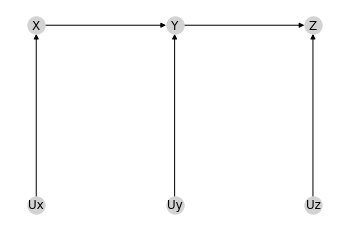

In [13]:
sq151 = oy.CausalDiagram([('Ux', 'X'), ('Uy', 'Y'), ('Uz', 'Z'), ('X', 'Y'), ('Y', 'Z')])
sq151pos = {'X': (0,0),'Y': (1,0),'Z': (2,0),'Ux': (0,-1),'Uy': (1,-1),'Uz': (2,-1),}
oy.draw(sq151, pos=sq151pos)

The rest of Study Question 1.5.1 is analytical in nature, we skip it here but many statistical python packages (such as `statsmodels`) can be used to answer or simulate the analytical questions in the Primer.

## Graphical Models and Their Applications <a id="graphsAndApps"></a>

### Study Question 2.3.1 <a id="sq231"></a>

#### a) List all pairs of variables in Figure 2.5 that are independent, conditional on the set Z = {R, V}

Since this graph is linear, I can simply print it using `print_path`. I could also have drawn it using `draw`.

In [14]:
fig2_5 = oy.CausalDiagram([('X', 'R'), ('R', 'S'), ('S', 'T'), 
                           ('U', 'T'), ('V', 'U'), ('V', 'Y')])
print('Figure 2.5\n')
oy.print_path(fig2_5, start='X')

Figure 2.5

X -> R -> S -> T <- U <- V -> Y


Two variables are independent if the path between them is blocked by the conditioned variables.  If not, the variables are possibly (actually very likely, with a few specific  exceptions) dependent. Oyster's `d_separated` function generalizes the idea of blocking to arbitrary sets of potentially independent variables and conditioners.

In [15]:
Z = {'R', 'V'}
print('Given {R,V}...')
for a,b in oy.combinations(fig2_5.nodes - Z, 2): # for all pairs of nodes not in Z...
    ind = oy.d_separated(fig2_5, a, b, Z)
    if ind: print(f'{a} and {b} are independent.')
    else: print(f'{a} and {b} are possibly dependent.')

Given {R,V}...
U and X are independent.
U and T are possibly dependent.
U and Y are independent.
U and S are independent.
X and T are independent.
X and Y are independent.
X and S are independent.
T and Y are independent.
T and S are possibly dependent.
Y and S are independent.


<a id="d_sep_graph"></a>
Pearl defines path d-seperation in terms of graphic structures called chains (A -> B -> C), forks (A <- B -> C) and colliders (A -> B <- C):  A path is blocked by a set of nodes Z iff the path contains a chain or fork such that the middle node (B above) is in Z, or the path contains a collider such that B is *not* in Z. Two nodes X and Y are d-separated by Z iff Z contains nodes that block every path between X and Y. 

Another way to understand d-seperation is the following ***graphical algorithm***, which automatically checks every path according to Pearl's rules above and works for multi-variable sets of X, Y, and/or Z:
1. Draw the "ancestral graph" of the variables in question, i.e. the subgraph containing X, Y, Z, and their ancestors.
1. "Moralize" the ancestral graph by adding edges between all parents of a node.
1. Draw a subgraph of the moral graph, omitting nodes in Z.
1. If X and Y are now disconnected, Z d-separates X and Y.

Oyster provides a visualization for this algorithm with `d_sep_graphs`. Credit to [this worksheet](http://web.mit.edu/jmn/www/6.034/d-separation.pdf) from MIT.

X d-separated from Y by {'U', 'R'}? True


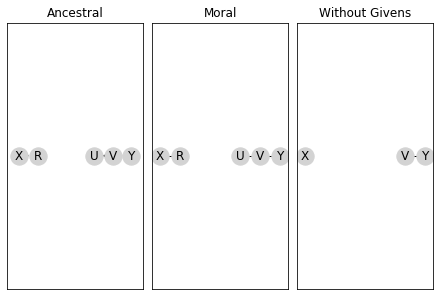

In [16]:
fig = oy.ex.primer['fig2_5']
X,Y,Z = 'X', 'Y', {'R','U'}
print(f'{X} d-separated from {Y} by {Z}? {oy.d_separated(fig, X, Y, Z)}')
oy.d_sep_graphs(fig, X, Y, Z)

#### b) For each pair of non-adjacent variables in Figure 2.5, give a set of variables that, when conditioned on, renders that pair independent.

Oyster provides a utility function `NA_pairs` for selecting the nonadjacent pairs in a graph.

Oyster's `d_separator_search` function conducts an exhaustive search for d_seperators over all possible combinations of the other nodes in a graph.  For simplicity, we select just one below.

In [17]:
for a,b in oy.NA_pairs(fig2_5):
    separators = oy.d_separator_search(fig2_5, a, b)[0] # just one set.
    print(f'{a},{b}: {separators}')

X,S: {'R'}
X,T: {'R'}
X,U: set()
X,V: set()
X,Y: set()
T,R: {'S'}
U,R: set()
V,R: set()
Y,R: set()
U,S: set()
V,S: set()
Y,S: set()
T,V: {'U'}
T,Y: {'U'}
Y,U: {'V'}


`set()` means that no variables need be conditioned on to render the pair independent.  In other words, they are *marginally independent*.


See [further discussion](#impliedIndependencies) of this concept of `implied independencies` and a better, dedicated Oyster tool for finding them in study question 2.4.1 below.

#### c) List all pairs of variables in the graph of Figure 2.6 that are independent conditional on the set Z={R,P}.

Pulling the graph from `oyster.examples`...

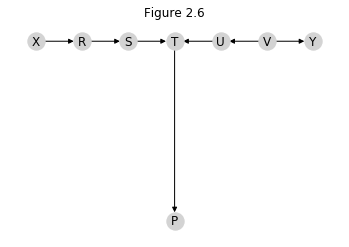

In [18]:
fig2_6 = oy.ex.primer['fig2_6']
oy.draw(fig2_6, title='Figure 2.6')

as in part a)...

In [19]:
Z = {'R', 'P'}
print('Given {R,P}...')
for a,b in oy.combinations(fig2_6.nodes - Z, 2): # for all pairs of nodes not in Z...
    ind = oy.d_separated(fig2_6, a, b, Z)
    if ind: print(f'{a} and {b} are independent.')

Given {R,P}...
U and X are independent.
X and T are independent.
X and V are independent.
X and Y are independent.
X and S are independent.


#### d) For each pair of non-adjacent variables in Figure 2.6, give a set of variables that, when conditioned on, renders that pair independent.

as in part b) (and recalling that I show [a better way below](#impliedIndependencies) using `implied_indepenencies`).

In [20]:
for a,b in oy.NA_pairs(fig2_6):
    separators = oy.d_separator_search(fig2_6, a, b)[0] # just one set.
    print(f'{a},{b}: {separators}')

X,S: {'R'}
X,T: {'R'}
X,P: {'R'}
X,U: set()
X,V: set()
X,Y: set()
T,R: {'S'}
P,R: {'T'}
U,R: set()
V,R: set()
Y,R: set()
P,S: {'T'}
U,S: set()
V,S: set()
Y,S: set()
T,V: {'U'}
T,Y: {'U'}
U,P: {'T'}
V,P: {'U'}
Y,P: {'U'}
Y,U: {'V'}


#### e) Suppose we generate data by the model described in Figure 2.5, and we fit them with the linear equation Y = a + bX + cZ. Which of the variables in the model may be chosen for Z so as to guarantee that the slope b would be equal to zero?

b = 0 iff X and Y are independent.  So in other words, which (single) variables Z d-separate X and Y?

In [21]:
[z for z in oy.d_separator_search(fig2_5, 'X', 'Y') if len(z) == 1]

[{'U'}, {'R'}, {'V'}, {'S'}]

#### f) Continuing question (e), suppose we fit the data with the equation: 

\begin{equation*}
Y = a + bX + cR + dS + eT + fP
\end{equation*}

#### which of the coefficients would be zero?

Here, the question can be reworded as "which of {X, R, S, T, P} is independent of Y, given the rest of the variables?"

In [22]:
variables = {'X', 'R', 'S', 'T', 'P'}

[v for v in variables if oy.d_separated(fig2_6, v, 'Y', variables - {v})]

['P', 'X', 'R']

### Study Question 2.4.1 <a id="sq241"></a>
#### Considering Figure 2.9...

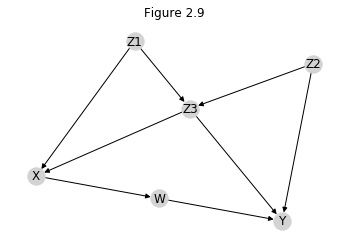

In [23]:
fig2_9 = oy.ex.primer['fig2_9']
oy.draw(fig2_9, title='Figure 2.9')

#### a) For each pair of non-adjacent nodes in this graph, find a set of variables that d-separates that pair. What does this list tell us about independencies in the data?

<a id="impliedIndependencies"></a>
If a pair of variables are d-separated, they are independent of one another, conditional on the variables that d-separate them.

This concept is important because these ***implied independancies*** represent ***testable implications*** of a model. Given a dataset and a causal diagram proporting to explain it, one can examine the if two varaibles remain correlated after controlling for factors that d-separate the variables in the causal diagram. If so, then the model is flawed.

Oyster provides a top-level function for finding displaying the independencies implied by a model.

In [24]:
oy.implied_independencies(fig2_9)

Implied independencies:
X ⫫ Y | [{'Z2', 'W', 'Z3'}, {'Z1', 'W', 'Z3'}]
X ⫫ Z2 | [{'Z1', 'Z3'}]
Z1 ⫫ W | [{'X'}]
W ⫫ Z3 | [{'X'}]
Z2 ⫫ W | [{'X'}, {'Z1', 'Z3'}]
Z1 ⫫ Y | [{'Z2', 'W', 'Z3'}, {'Z2', 'Z3', 'X'}]
Z2 ⫫ Z1 | [set()]


<a id="minsets"></a>
Note that each set in the above lists represents a minimal separating set.  So, X and Y are independent given Z1, W, and Z3.  X and Y are also independent given Z2, W, and Z3.  Z1 and Z2 are independent without controlling for any variables.  There are more seperating sets for Figure 2.9 than the minimal sets listed above, but every other set is a superset of the minimal sets, (i.e. they include at least one extraneous variable).  ***Minimal separating sets*** are an important concept because they allow independencies to be analyzed with as few covariate adjustments as possible, which among other good things means the sample sizes for each matching covariate category are larger.  Oyster provides a utility function `minimal_sets` that determines the minimal sets from a provided list of sets.

Another way to examine d-separating sets would be to run a `d_separator_search` for each nonadjacent pair. This is what `implied_independancies` does behind the scenes, returning only the `minimal_sets`.

In [25]:
all_X_Y_d_separators = oy.d_separator_search(fig2_9, 'X', 'Y')
print('d-separating sets for X ⫫ Y in Figure 2.9:')
print(f'All: {all_X_Y_d_separators}')
print(f'Minimal: {oy.minimal_sets(all_X_Y_d_separators)}')

d-separating sets for X ⫫ Y in Figure 2.9:
All: [{'Z2', 'W', 'Z3'}, {'Z1', 'W', 'Z3'}, {'Z2', 'Z1', 'W', 'Z3'}]
Minimal: [{'Z2', 'W', 'Z3'}, {'Z1', 'W', 'Z3'}]


#### b) Repeat question (a) assuming that only variables in the set {Z3,W,X,Z1} can be measured.

Now, instead of taking the minimal sets as is done with `implied_independencies`, we will run an exhaustive `d_separator_search` against nonadjacent pairs, and filter the results such that the seperating sets include only measurable variables, and only for measurable pairs.

In [26]:
measurable = {'Z3','W','X','Z1'}

all_d_seps_for_measurable_pairs = [(a,b, oy.d_separator_search(fig2_9, a, b))
                                   for a,b in oy.NA_pairs(fig2_9) 
                                   if a in measurable and b in measurable]

for (a,b,sep) in all_d_seps_for_measurable_pairs:
    print(f'{a} ⫫ {b} | {list(filter(lambda s: s < measurable, sep))}')

Z1 ⫫ W | [{'X'}, {'X', 'Z3'}]
W ⫫ Z3 | [{'X'}, {'X', 'Z1'}]


#### c) For each pair of non-adjacent nodes in the graph, determine whether they are independent conditional on all other variables.

In [27]:
for (a,b) in oy.NA_pairs(fig2_9):
    all_other_variables = fig2_9.nodes - {a} - {b}
    ind = oy.d_separated(fig2_9, a, b, all_other_variables)
    if ind: print(f'{a} ⫫ {b} | {all_other_variables}')

X ⫫ Y | {'Z2', 'Z1', 'W', 'Z3'}
X ⫫ Z2 | {'Z1', 'W', 'Z3', 'Y'}
Z1 ⫫ W | {'Z2', 'Z3', 'Y', 'X'}
Z1 ⫫ Y | {'Z2', 'W', 'Z3', 'X'}


#### d) For every variable V in the graph, find a minimal set of nodes that renders V independent of all other variables in the graph.

An important result from Bayesian Network theory is that V is independent of all other variables in the graph given the set of V's parents, V's children, and all the other parents of V's children.  This set is also guaranteed to be minimal.  This set is known as a variable's ***Markov Blanket***, and is accessed by the `MB` utility function.

In [28]:
for node in fig2_9.nodes:
    mb = oy.MB(fig2_9, node)
    print(f'{node} ⫫ {fig2_9.nodes - mb} | {mb}')

X ⫫ {'X', 'Y', 'Z2'} | {'Z1', 'W', 'Z3'}
W ⫫ {'Z1', 'W'} | {'Z2', 'Z3', 'Y', 'X'}
Y ⫫ {'X', 'Z1', 'Y'} | {'Z2', 'W', 'Z3'}
Z1 ⫫ {'Z1', 'W', 'Y'} | {'Z2', 'Z3', 'X'}
Z3 ⫫ {'Z3'} | {'Z2', 'X', 'Z1', 'W', 'Y'}
Z2 ⫫ {'X', 'Z2'} | {'Z1', 'W', 'Z3', 'Y'}


#### e) Suppose we wish to estimate the value of Y from measurements taken on all other variables in the model. Find the smallest set of variables that would yield as good an estimate as before.

<a id="mb"></a>
This is an important application of the [Markov Blanket](https://en.wikipedia.org/wiki/Markov_blanket). As a corollary from the above discussion, a variable V's Markov Blanket is the minimal set of variables that contain the knowledge needed to predict V.

In [29]:
oy.MB(fig2_9, 'Y')

{'W', 'Z2', 'Z3'}

Alternatively, if you were a glutton for punishment you could take the minimal set of the intersection of the sets of sets that d-separate Y from every nonadjacent node:

In [30]:
separating_sets_for_NA_nodes = [oy.d_separator_search(fig2_9, 'Y', node)
                                for node in oy.NA(fig2_9, 'Y')]

intersection = {frozenset(s) for s in separating_sets_for_NA_nodes[0]}
for node in separating_sets_for_NA_nodes[1:]:
    intersection.intersection_update({frozenset(s) for s in node})

[set(s) for s in intersection]

[{'W', 'Z2', 'Z3'}]

#### f) Repeat Question (e) assuming that we wish to estimate the value of Z2

In [31]:
oy.MB(fig2_9, 'Z2')

{'W', 'Y', 'Z1', 'Z3'}

#### g) Suppose we wish to predict the value of Z2 from measurements of Z3. Would the quality of our prediction improve if we add measurement of W? Explain.

In other words...is W d-separated from Z2, given Z3?

In [32]:
oy.d_separated(fig2_9, 'Z2', 'W', 'Z3')

False

<a id="variableSelection"></a>
Answer: "Probably, but...".  W is not d-separated from Z2 given Z3.  If it *were* d-separated (i.e. conditionally independent, given Z3), then adding it to the model would not add additional information and the answer would be a definite "No."  Since in fact W is not d-separated from Z2 given Z3 (i.e. it remains correlated), including it will improve (in-sample) prediction, at least as measured by $R^{2}$ ... but the improvement will not necessarily be worth the cost of making the model less parsimonious.

To summarize the value of graphical analysis for ***variable selection***: a model implies that some variables (those that are d-separated, a.k.a independent of the variable to be predicted, conditional on the other variables being measured), are certainly not worth including when making predictions.  Variables that grahical analysis shows are d-connected may or may not have value.

### Study Question 2.5.1 <a id="sq251"></a>

#### a) Which of the arrows in Figure 2.9 can be reversed without being detected by any statistical test?
#### b) List all the graphs that are observationally equivalent to the one in Figure 2.9.
#### c) List the arrows in Figure 2.9 whose directionality can be determined from nonexperimental data.

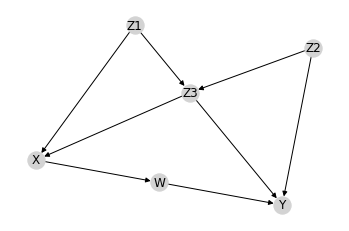

In [33]:
oy.draw(fig2_9) # Still using fig2_9 as above

The "statistical tests" mentioned above check for independencies between variables. So in other words, the question asks: How many graphs can be formed from reversing the direction of any edge in Figure 2.9, while stil implying the same set of independencies?  

<a id="cpdag"></a>
The set of graphs with the same skeleton and implied independencies is called an ***equivalence class.*** Oyster provides a function for the `equivalence_class_size` of a given causal diagram.

In [34]:
oy.equivalence_class_size(fig2_9)

1

An equivalence class size of 1 means that, in Figure 2.9, *no arrows* can be reversed without the resulting graph having a different set of implied independencies (part a).  Similarly, there are no other observationally equivalent graphs (part b), and all arrows can be determined from nonexperimental data (part c).  It's a trick question!

The ***Complete Partial DAG (CPDAG)*** is a related concept to equivalence class.  The CPDAG is a partially-directed graph, where edges that are *compelled* to have a certain direction based on implied independencies are represented as normal, but edges that can be reversed are shown as undirected (or, equivalently, with arrows at both ends).  CPDAGs summarize an equivalence class in a single graph; pick an arbirary direction for each undirected edge and the reslting graph is a member of the same equivalence class.  The size of an equivalence class is thus $2^{n}$, where n is the number of reversible edges in the CPDAG.

CPDAGs and equivalence classes have two important applications:
    
1. In the field of ***causal search***, a dataset is interrogated for any independence relationships between variables, and the resulting independencies can be used to generate a graph that explains the data.  Think of this as going in reverse from how we've considered graphs so far: where so far we have we hyppothesized a causal diagram that can verified against the data, causal search takes the data and generates a graph that fits.  The catch is that these causal search methods can only go so far, because there might be several graphs that explain the data, with arrows in different directions so long as they don't violate an independence in the data.

1. CPDAG's summarize the valid ***alternative hypotheses*** that could correctly explain a dataset, in addition to a given valid causal model.  In many fields it pays to be aware of the fact that different explainations could exist that are just as consistent with the collected data; articulating these alternative competing hypotheses is a starting point for devising followon experiments that can focus on deciding between alternative models.

Oyster's `dag_to_cpdag` function returns a CPDAG from a given DAG.  As expected, the CPDAG for Figure 2.9 is the same as Figure 2.9; all of the edges are compelled to one direction by Figure 2.9's implied independencies.

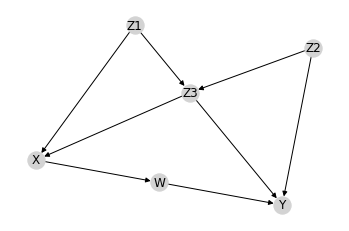

In [35]:
oy.draw(oy.dag_to_cpdag(fig2_9), pos=oy.ex.pos[fig2_9])

For a more illuminating example, let's look at Figure 1.8. Oyster also provides a visualization function `draw_cpdag` tht draws the graph and its CPDAG side-by-side.

equivalent dags: 128


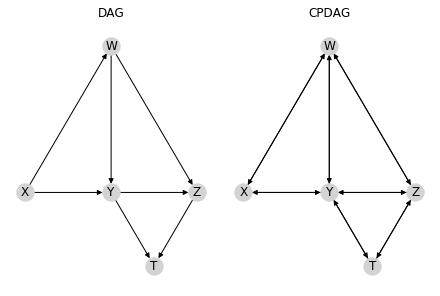

In [36]:
oy.draw_cpdag(fig1_8, pos=oy.ex.pos[oy.ex.primer['fig1_8']])

Every one of the directed edges in Figure 1_8 can be reversed, while still implying the same independencies!

#### d) Write down a regression equation for Y such that, if a certain coefficient in that equation is nonzero, the model of Figure 2.9 is wrong.

Again, we check the implied independencies:

In [37]:
oy.implied_independencies(fig2_9)

Implied independencies:
X ⫫ Y | [{'Z2', 'W', 'Z3'}, {'Z1', 'W', 'Z3'}]
X ⫫ Z2 | [{'Z1', 'Z3'}]
Z1 ⫫ W | [{'X'}]
W ⫫ Z3 | [{'X'}]
Z2 ⫫ W | [{'X'}, {'Z1', 'Z3'}]
Z1 ⫫ Y | [{'Z2', 'W', 'Z3'}, {'Z2', 'Z3', 'X'}]
Z2 ⫫ Z1 | [set()]


We see that Y should be independent of X given W, Z1, and Z3.  Thus, in a regression equation Y ~ aX + bW + cZ1 + dZ3, if a is nonzero, (implying X and Y are *not* independent), the model would be wrong.

#### e) Repeat part (d) for variable Z3.

As above, `oy.implied_independencies` shows us that W and Z3 are independent given X.  So a regression Z3 ~ fW + gX, f should be zero.

#### f) Repeat part (e), assuming X is not measured.

If X is immeasurable, we aren't able to use it in a regression equaition.  Since the only independence relationship for Z3 above must include X, we conclude that we write a rgression equation that to test the model without X. Another trick question!

#### g) How many regression equations of the type described in (d) and (e) are needed to ensure that the model is fully tested, namely, that if it passes all these tests it cannot be refuted by additional tests of these kind.

This set of equations is called a ***basis set***.  In other words, were looking for a set of equations that show a variable is independent of its non-decendents, given its parents.  This set mirrors the *Rule of Product Decomposition*, which says that for an acyclic graph, 

\begin{equation*}
P(x_{1}, x_{2}, ..., x_{n}) = \prod_{i}P(x_{i}|pa_{i})
\end{equation*}

Oyster provides a function to print these independencies under `basis_set`

In [38]:
oy.basis_set(fig2_9)

X ⫫ {'Z2'} | {'Z1', 'Z3'}
W ⫫ {'Z2', 'Z1', 'Z3'} | {'X'}
Y ⫫ {'X', 'Z1'} | {'Z2', 'W', 'Z3'}
Z1 ⫫ {'Z2'} | set()
Z2 ⫫ {'Z1'} | set()


The independence relations for Z1 and Z2 are the same, so we really only need 4 equations.  

## The Effects of Interventions <a id="interventions"></a>

### Study Question 3.3.1 <a id="sq331"></a>
Consider the graph of Figure 3.8:

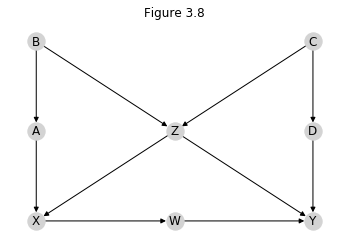

In [39]:
fig3_8 = oy.ex.primer['fig3_8']
oy.draw(fig3_8, title='Figure 3.8')

### a) List all of the sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y.

To satisfy the ***Back-door Criterion***, a set of variables must d-seperate the "backdoor paths", i.e. the paths from X to Y that start with an edge into X, not out of X. Oyster has a function to check that a variable or set of variables satisfies the backdoor criterion, `meets_backdoor_criterion`, but it will also do an exhaustive search for all backdoor separators with `backdoor_criterion_search`.

In [40]:
oy.backdoor_criterion_search(fig3_8, 'X', 'Y')

[{'C', 'Z'},
 {'B', 'Z'},
 {'A', 'Z'},
 {'D', 'Z'},
 {'B', 'C', 'Z'},
 {'A', 'C', 'Z'},
 {'C', 'D', 'Z'},
 {'A', 'B', 'Z'},
 {'B', 'D', 'Z'},
 {'A', 'D', 'Z'},
 {'A', 'B', 'C', 'Z'},
 {'B', 'C', 'D', 'Z'},
 {'A', 'C', 'D', 'Z'},
 {'A', 'B', 'D', 'Z'},
 {'A', 'B', 'C', 'D', 'Z'}]

### b) List all of the *minimal* sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y.

In [41]:
oy.minimal_sets(oy.backdoor_criterion_search(fig3_8, 'X', 'Y'))

[{'C', 'Z'}, {'B', 'Z'}, {'A', 'Z'}, {'D', 'Z'}]

### c) List all minimal sets of variables that need be measured to identify the effect of D on Y.

As with d-separators, Oyster can accept arbitrary sets of cause and effect variables.

In [42]:
oy.minimal_sets(oy.backdoor_criterion_search(fig3_8, {'W', 'D'}, 'Y'))

[{'Z'}, {'C', 'X'}]

Oyster also provides a function `backdoor_adjustment_formula` that generates a Latex expression for the ***Back-Door Adjustment Formula***, which translates from the graphical analysis of specifying a backdoor adjustment set into a symbolic formula for calculating the causal effect from observed data.  The function will also check behind the scenes to confirm the specified adjustment set does indeed meet the backdoor criterion.

In Oyster's notation, a P with a subscript indicates an interventional probability, and lower case letters represent specific values of the upper case variables.  So: $P(Y = y | do(X=x)) = P_{x}(y)$.

You can view the Latex expression in a Jupyter notebook by importing `Math` from `IPython.display`. 

In [43]:
from IPython.display import Math
Math(oy.backdoor_adjustment_formula(fig3_8, {'W', 'D'}, 'Y', 'Z'))

<IPython.core.display.Math object>

## Study Question 3.3.2 (Lord's Paradox) <a id="sq332"></a>

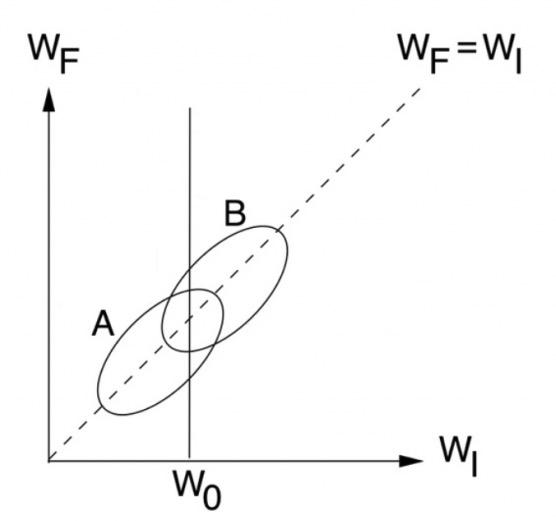

In [44]:
from IPython.display import Image
Image('oyster/example/lords_paradox.png', width=300)
# Credit: Judea Pearl (http://causality.cs.ucla.edu/blog/index.php/2019/08/13/lords-paradox-the-power-of-causal-thinking/)

>   A boarding school offers two meal plans over a school year: Plan A, and Plan B.  The students' initial weight $W_{I}$ and final weights $W_{F}$ are recorded. To determine how each plan affects students' weight gain, the school hires two statisticians who, oddly, reach different conclusions.  
>
> The first statistician calculates $W_{F} - W_{I}$ for each student and finds that the average weight gain in each plan was zero. This can be seen in the figure by noting that the ovals representing the spread of weight measurements are symmetric around the line $W_{F} = W_{I}$.
>
> The second statistician subdivides the students into several subgroups by initial weight. For each individual weight, the final weight is higher for Plan B than the final weight for Plan A.  I.e., for any choice of $W_{I} = W_{0}$ in the figure, the average $W_{F}$ for dining Plan B is more than the average $W_{F}$ for dining Plan A.
>
> The first statistician thus concludes that there was no effect of diet on weight gain and the second statistician concludes that plan B caused students to gain more weight.

### Which statistician is right?  How can it be that two statisticians can reach two different conclusions about the same data?

This classic example showcases the utility of causal graphs for ***causal argumentation*** <a id="arg"></a>, because a causal graph makes the assumptions behind adjustment procedures explicit.  

The difference in conclusions stems from the fact that statistician 1 did not control for initial weight, whereas statistician 2 did.  Each statistician made an impicit assumption about the causal relationships between the variables in the study, and performed the correct adjustment associated with that assumption.  

If forced to draw a causal graph representing his model, Statistician 1 might have drawn either of the following three models.  In each graph, Wi is not on the backdoor path from Plan to Wf, so there is no need to adjust for Wi.

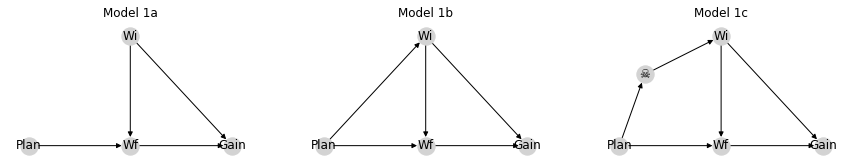

In [45]:
model1a = oy.CausalDiagram([('Wi', 'Wf'), ('Plan', 'Wf'), ('Wi', 'Gain'), ('Wf', 'Gain')])
model1b = oy.CausalDiagram([('Wi', 'Wf'), ('Plan', 'Wf'), ('Plan', 'Wi'), ('Wi', 'Gain'), ('Wf', 'Gain')])
model1c = oy.CausalDiagram([('Wi', 'Wf'), ('Plan', 'Wf'), ('Plan', '☠'), ('☠', 'Wi'), ('Wi', 'Gain'), ('Wf', 'Gain')])

lords_pos ={'Plan': (0,0), 'Wi': (1,1), 'Wf': (1,0), 'Gain': (2,0), '☠': (.25, .65), 'Eating Habits': (.25, .65)}
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1,3, figsize=(15,2.5))
oy.draw(model1a, pos=lords_pos, title='Model 1a', ax=axs1[0])
oy.draw(model1b, pos=lords_pos, title='Model 1b', ax=axs1[1])
oy.draw(model1c, pos=lords_pos, title='Model 1c', ax=axs1[2])

However, none of these graphs are particularly plausible.  Model 1a implies that the meal plan was unrelated to Wi, (or, equivalently, that it was assigned at random), but from the data we can clearly see that the populations that received meal plan A differed from the population that received plan B in terms of Wi.  Model 1b stipulates that plan assignment caused initial weight, which is hard to imagine except possibly in a scenario like model 1c, where plan assignment had an effect on initial weight via some intermediary --- e.g. a bout of food poisoning (represented by node '☠' on the graph) caused those in plan A to lose lots of weight immediately before the initial weight measurement.  So it's *possible* to contort a model that justifies not cotrolling for Wi, but once laid bare the model's assumptions can be checked against data and expert knowledge.

The second statistician could draw graphs such as the two below to justify adjusting for Wi:

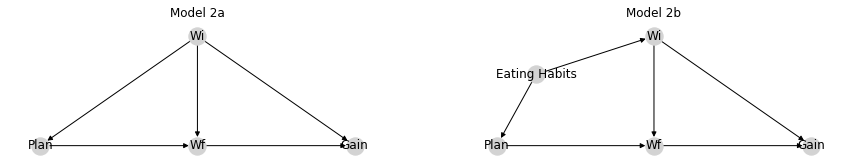

In [46]:
model2a = oy.CausalDiagram([('Wi', 'Wf'), ('Wi', 'Plan'), ('Plan', 'Wf'), ('Wi', 'Gain'), ('Wf', 'Gain')])
model2b = oy.CausalDiagram([('Wi', 'Wf'), ('Eating Habits', 'Plan'), ('Eating Habits', 'Wi'), ('Plan', 'Wf'), ('Wi', 'Gain'), ('Wf', 'Gain')])

fig2, axs2 = plt.subplots(1,2, figsize=(15,2.5))
oy.draw(model2a, pos=lords_pos, title='Model 2a', ax=axs2[0])
oy.draw(model2b, pos=lords_pos, title='Model 2b', ax=axs2[1])

These models stipulate that the students' meal plan assignment was either directly influenced by their initial weight, or a confounder introduced a selection bias into which children recieved which plan, e.g., children chose their own meal plans, and those with poor eating habits were more likely to choose meal plan B while also being more likely to have a higher initial weight.  In this case Wi is on a backdoor path from Plan to Gain, and controlling for Wi satisfies the backdoor criterion, allowing for the appropriate estimation of causal effect.  

Either of statistician 2's models seems more plausible than the models fitting the procedure followed by statistician 1 based on what we know from the example, but more importantly, the models provide a common language in which to explicitly reason about, argue for, and explain their chosen assumptions. 

**Bonus**: As an exercise to the reader, imagine a different scenario where a school wants to determine whether the single meal plan it offers in its cafeteria has different effects on girls vs. boys.  The data are arrayed just as in the above figure, but A and B represent girls and boys, as opposed to the students assigned to different meal plans.  By drawing causal graphs one should see that in this case the most convincing argument is in favor of *not* adjusting for Wi, and thus conclude that the single meal plan does not affect girls and boys differently.

## Study Question 3.4.1
### Assume that in Figure 3.8, only X, Y, and one additional variable can be measured.  Which variable would allow the identification of the effect of X on Y? What would that effect be?

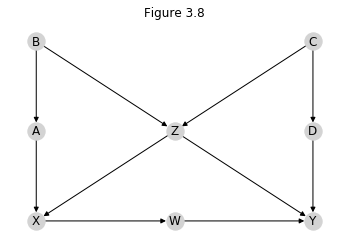

In [47]:
oy.draw(fig3_8, title='Figure 3.8')

Recalling from Study Question 3.3.1, all the minimal adjustment sets that satisfy the backdoor criterion have at least two variables, Z and either A, B, C, or D.

Fortunately, backdoor adjustment isn't the only way to identify causal effects.  Another simple method is the ***Front-Door Criterion***, which is satisfied by a set of variables Z for the effect of X on Y if:
    
1. Z intercepts all directed paths from X to Y.
1. There is no backdoor path from X to Z.
1. All backdoor paths from Z to Y are blocked by X.

Oyster provides a function `frontdoor_criterion_search`, to identify any frontdoor adjustment sets.

In [48]:
oy.frontdoor_criterion_search(fig3_8, 'X', 'Y')

[{'W'}]

Oyster also provides the Latex expression of the formula for front-door adjustment with `frontdoor_adjustment_formula`.

The ***Front-Door Adjustment Formula*** can be derived via two applications of the backdoor adjustment formula, once for the effect of X on Z (adjusting on the null set as we stipulate there is no backdoor path), and again for the effect of Z on Y, adjusting for X: 

In [49]:
Math(oy.frontdoor_adjustment_formula(fig3_8, 'X', 'Y', 'W'))

<IPython.core.display.Math object>

Here $x'$ is just an index of summation: the second term of the formula should be summed over all states of X.

## Study question 3.5.1 <a id="sq351"></a>
### Continuing with Figure 3.8...

### a) Find an expression for the c-specific effect of X on Y.

That is, the causal effect of X on Y, conditioning on C.   The process for finding  ***specific effects*** <a id="specificEffects"></a> involves finding a valid adjustment set that includes C. 

Specific effects have at several important uses in causal inference:

1. Computing specific effects are an essential step in examining ***effect modification or moderation***.  A policy question might revolve around the effect of X on Y for a specific subpopulation with characteristics W = w.  Another policy question might ask how the effect of X on Y changes if W changes from w to w'.
2. When a policy under evaluation involves a ***dynamic or conditional intervention***, where the value of X changes based on the value of some set of other covariates Z (e.g. age, weight, etc.).  The act of conditioning X on Z amounts to conditioning on Z, and thus the effect of X on Y is a Z-specific effect.
3. Comparing causal effects from different adjustment sets (i.e. different specific effects) is another ***testable constraint*** on model, in addition to the implied independencies discussed earlier.  The effect of X on Y should ideally be the same no matter our choice of Z (provided each Z satisfies the backdoor criterion).  When the calculated specific causal effects differ significantly, it should call the validty of the model into question.

In Oyster, finding a specific adjustment set can be done with a simple filter or conditional list comprehension:

In [50]:
[s for s in oy.backdoor_criterion_search(fig3_8, 'X', 'Y') if 'C' in s]

[{'C', 'Z'},
 {'B', 'C', 'Z'},
 {'A', 'C', 'Z'},
 {'C', 'D', 'Z'},
 {'A', 'B', 'C', 'Z'},
 {'B', 'C', 'D', 'Z'},
 {'A', 'C', 'D', 'Z'},
 {'A', 'B', 'C', 'D', 'Z'}]

Oyster also provides a `specific_adjustment_sets` function that does the same thing.  Let's also just pick out the minimal sets:

In [51]:
oy.minimal_sets(oy.specific_adjustment_sets(fig3_8, 'X', 'Y', 'C'))

[{'C', 'Z'}]

The expression for calculating the z-specific effect is a slight modification of the backdoor adjustment formula, which amounts to separating Z out from the other adjustment variables S as a conditional.  But in any case, the set $Z \cup S$ must satisfy the backdoor criterion.  Oyster checks this condition and outputs the appropriate Latex with `specific_adjustment_formula`, which in addition to parameters for the causal diagram, X, Y, and Z, also requires S, the set of any variables in addition to Z necessary to satisfy the backdoor criterion.

In [52]:
Math(oy.specific_adjustment_formula(fig3_8, 'X', 'Y', 'Z', 'C'))

<IPython.core.display.Math object>

### b) Identify a set of four variables that need to be measured in order to estimate the z-specific effect of X on Y, and find an expression for the size of that effect.

Let's filter the `specfic_adjustment_sets` for 'Z' to just those containing four elements:

In [53]:
sets = [s for s in oy.specific_adjustment_sets(fig3_8, 'X', 'Y', 'Z') if len(s) == 4]
for s in sets: print(s)

{'A', 'C', 'B', 'Z'}
{'C', 'B', 'D', 'Z'}
{'A', 'C', 'D', 'Z'}
{'A', 'B', 'D', 'Z'}


And again using `specific_adjustment_formula` to give an expression for one of those sets:

In [54]:
Math(oy.specific_adjustment_formula(fig3_8, 'X', 'Y', 'Z', sets[0] - {'Z'}))

<IPython.core.display.Math object>

## Controlled Direct Effects <a id="cde"></a> (Under Construction)


- CDE identifiable (implement)
- CDE Formula

## Instrumental Variables

Back-door and Front-door adjustment are two ways of determining the effect of X on Y in a causal model from observational data, but it is not always possible to find variables that meet the back- or front-door criteria, particularly when certain potential confounders are not observable.  Fortunately there are other ways to identify a causal effects. One common approach is to search a causal diagram for ***instrumental variables***.

Consider this graph and its front and backdoor adjustment sets:

Back-Door Adjustment Sets: [{'U'}, {'U', 'Z'}]
Front-Door Adjustment Sets: []


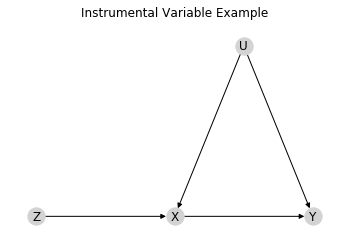

In [55]:
iv = oy.CausalDiagram([('Z', 'X'), ('X', 'Y'), ('U', 'X'), ('U', 'Y')])
iv_pos = {'Z': (0,0), 'X': (1,0), 'Y': (2,0), 'U': (1.5, .5), 'W': (2,1)}
oy.draw(iv, pos=iv_pos, title='Instrumental Variable Example')

print(f"Back-Door Adjustment Sets: {oy.backdoor_criterion_search(iv, 'X', 'Y')}")
print(f"Front-Door Adjustment Sets: {oy.frontdoor_criterion_search(iv, 'X', 'Y')}")

For the effect of X->Y, there are no front-door adjusters, and both back-door adjustment sets include U.  Suppose U is unobservable (or U represents a suspected but unmeasurable common cause of X and Y).  Are we out of luck?  It turns out that, *under certain assumptions*, the answer is no!

Note that there are no backdoor paths from Z to X, nor are there any from Z to Y.  So those effects can be identified directly.  In this case Z can be called an *instrumental variable* relative to the effect of X on Y.

**If the relationships between X, Y, and Z are assumed to be linear**, then the causal effect of X on Y is simply the regression coefficent of Y on Z divided by the regression coefficient of X on Z.

In the nonlinear case, one can't simply take the ratio of coefficients, but under assumptions of ***monotonicity*** and ***exogeneity***, it might still be possible to calculate the effect of X on Y, or at least bound it.

Sometimes a variable might serve as an instrument conditional on some other set of variables.  Consider this graph:

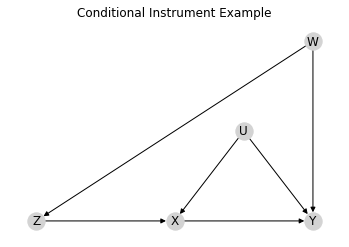

In [56]:
conditional_iv = oy.CausalDiagram([('Z', 'X'), ('X', 'Y'), ('U', 'X'), ('U', 'Y'), ('W', 'Z'), ('W', 'Y')])

oy.draw(conditional_iv, pos=iv_pos, title='Conditional Instrument Example')

Here there is a backdoor path from Z to Y, but if W is observable, that backdoor path can be blocked. So Z can be used as an instrument for determining X and Y, if we condition on W.

In general, Z is an instrumental variable, conditional on W if:
- Z and X *are not* d-separated by W,
- Z and Y *are* d-separated by W, and
- No nodes in W are descendants of Y (if they were, the graph would contain a collider that opens a path from Z to Y).

Oyster can help identify instrumental variables in a causal diagram using `instrumental_variable_search` which returns all instrumental variables and their associated minimal conditioning sets.\*  This can help ensure can help ensure that an appropriate instrument variable will be available when designing an experiment or data collection procedure.

\*For complicated graphs, it may be too computationally intensive to perform an exhaustive search; `ancestral_instrument_search` is a faster algorithm that guarantees finding an instrument if one exists, although the conditioning set may not be minimal.

Both functions return a tuple of the instrumental variable and its conditioning set (or the empty set if it is a pure instrumental variable).

In [57]:
print(f"IV for Instrumental Variable Example: {oy.instrumental_variable_search(iv, 'X', 'Y')}")
print(f"IV for Conditional Instrument Example: {oy.instrumental_variable_search(conditional_iv, 'X', 'Y')}")

IV for Instrumental Variable Example: [('Z', [set()])]
IV for Conditional Instrument Example: [('Z', [{'W'}])]


## General Identifiability <a id="id"></a> (Under Construction)

Lacking observable adjustment variables or instrumental variables, Pearl and several coauthors have developed a more general criteria.  In fact, their methods are complete: if it is possible to identify a causal effect, they will say so.  In symbolic form, these criteria are known as the ***do-calculus***.  Pearl and his colleagues (particularly Tian and Shpitser) also developed a graphical corrolary to the do-calculus, which Oyster implements as `is_identifiable`. Oyster currently implements Pearl and Shpitser's graphical algorithm in so far as it returns whether a graph is or is not identifiable; an extension is under development that outputs the appropriate adjustment formula.

The following graphs can be shown to be *not* identifiable for X -> Y when nodes starting with U are unobservable.

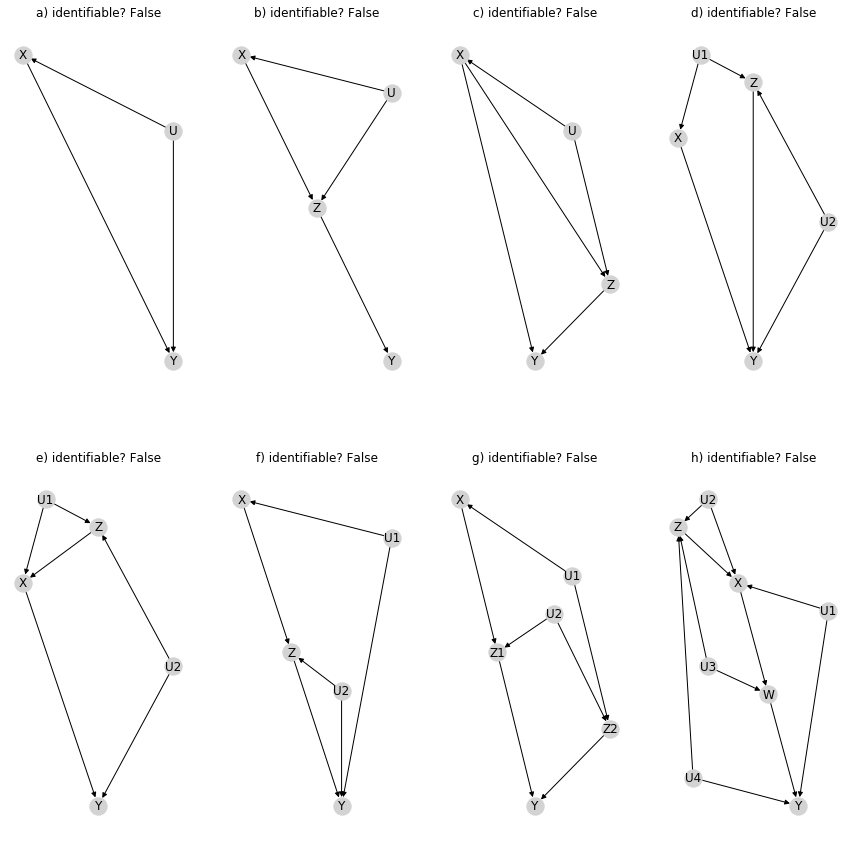

In [58]:
fig1, axs = plt.subplots(2,4, figsize=(15,15))
for i, (name, DAG) in enumerate(oy.ex.sp08['fig1'].items()):
    oy.draw(DAG, 
            title=f'{name}) identifiable? {oy.is_identifiable(DAG, "X", "Y")}',
            ax=axs.flatten()[i])

Whereas the following graphs are identifiable, even with 'U' nodes unobserable:

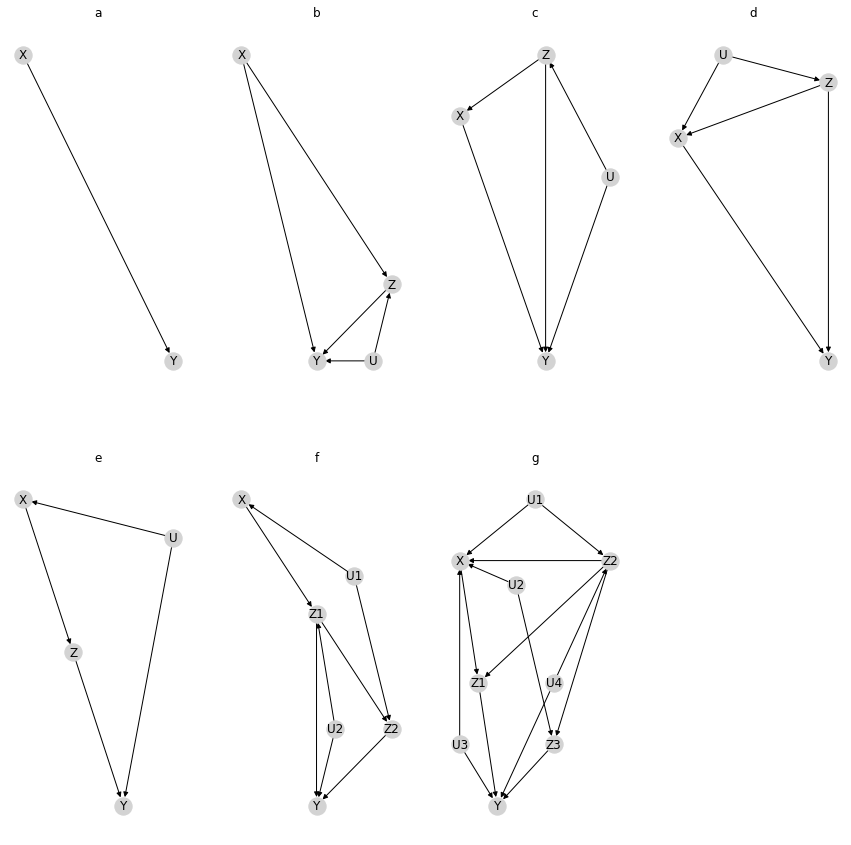

In [71]:
fig1, axs = plt.subplots(2,4, figsize=(15,15))
for ax, (name, DAG) in zip(axs.flatten(), oy.ex.sp08['fig2'].items()):
    oy.draw(DAG, 
            title=f'{name}',
            ax=ax)
axs[1][3].set_axis_off()

Some of these have backdoor adjusters, some frontdoor adjusters, (none have instrumental variables), but note that graphs f and g are still identifiable dispite not having any instrumental variables nor observable variables fitting the backdoor criterion, frontdoor criterion.

This is the 

In [77]:
for name, DAG in oy.ex.sp08['fig2'].items():
    hidden_vars =  {'U', 'U1', 'U2', 'U3', 'U4'} 
    ba_wo_U = [s for s in oy.backdoor_criterion_search(DAG, 'X', 'Y') 
               if not hidden_vars & s]
    
    fa_wo_U = [s for s in oy.frontdoor_criterion_search(DAG, 'X', 'Y') 
               if not hidden_vars & s]
    print(f'-------\nGraph {name}\n-------')
    print(f'Observable Backdoor adjustment sets: {ba_wo_U}')
    print(f"Observable Frontdoor adjustment sets: {fa_wo_U}")
    print(f"Instrumental variables: {oy.instrumental_variable_search(DAG, 'X', 'Y')}")
    print(f"Identifiable? {oy.is_identifiable(DAG, 'X', 'Y')}")

-------
Graph a
-------
Observable Backdoor adjustment sets: [set()]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph b
-------
Observable Backdoor adjustment sets: [set()]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph c
-------
Observable Backdoor adjustment sets: [{'Z'}]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph d
-------
Observable Backdoor adjustment sets: [{'Z'}]
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph e
-------
Observable Backdoor adjustment sets: []
Observable Frontdoor adjustment sets: [{'Z'}]
Instrumental variables: []
Identifiable? True
-------
Graph f
-------
Observable Backdoor adjustment sets: []
Observable Frontdoor adjustment sets: []
Instrumental variables: []
Identifiable? True
-------
Graph g
-------
Observable Backdoor adjustment sets: []
Obser

# Counterfactuals (Under Construction)

General, focus on application of graphical methods to identifying Counterfactuals. 
callbacks to backdoor for calculation, etc.)

- Counterfactual interpretation of backdoor
- Counterfactual identifiability (Shpitser)

- Examples?
    - Effect of the treatment on the treated (graphical example?)
        - Simple formula for binary X
    - Additive Interventions
    - Probability of Necessity (PN) and Blame
    - Probability of Sufficiency (PS) and Regret
    - PNS and Attribution
    - Monotoncity

pg. 112: "It is through counterfactual reinforcement that we learn to improve our decisionmaking processes and achive higher performance.